###طبقه بندی تصاویر با شبکه عصبی چند لایه

In [1]:
#@title Purpose:
%%html
<div style="direction:rtl">
هدف از انجام این پروژه دسته بندی تعدادی کالا بر اساس عکس آنهاست. برای انجام این کار از دیتاست زیر که شامل تعداد زیادی عکس دسته بندی شده است استفاده می کنیم.
</div>

In [39]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -n "/content/drive/My Drive/AI/CA5/categorized_products.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/AI/CA5/categorized_products.zip


In [49]:
DEFULT_LEARNING_RATE = 0.01
DEFULT_EPOCHS = 10
DEFULT_BATCH_SIZE = 64
IMG_SIZE = 60*80
IMG_FOLDER = 'categorized_products'
VALIDATION_SPLIT = 0.2
DEFULT_WEIGHT_DECAY = 0.1
PREVIEW_IMG_NUM = 12
TEST = "TEST"
TRAIN = "TRAIN"

import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta
from datetime import datetime
from sklearn.model_selection import train_test_split
import random 
plt.style.use('dark_background')

class Model1(nn.Module):
    def __init__(self, featureSize, classNum, modelData, act=F.relu, initWeights=False):
        super(Model1, self).__init__()

        self.layer1 = nn.Linear(featureSize, modelData[0])
        self.act1 = act

        self.layer2 = nn.Linear(modelData[0], modelData[1])
        self.act2 = act

        self.layer3 = nn.Linear(modelData[1], modelData[2])
        self.act3 = act

        self.layer4 = nn.Linear(modelData[2], modelData[3])
        self.act4 = act

        self.layer5 = nn.Linear(modelData[3], classNum)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

class Model2(nn.Module):
    def __init__(self, featureSize, classNum, modelData, act=F.relu, initWeights=False):
        super(Model2, self).__init__()

        self.layer1 = nn.Linear(featureSize, modelData[0])
        self.act1 = act

        self.layer2 = nn.Linear(modelData[0], modelData[1])
        self.act2 = act

        self.layer3 = nn.Linear(modelData[1], modelData[2])
        self.act3 = act

        self.layer4 = nn.Linear(modelData[2], classNum)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        return x

class CustomToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

class CustomToTensorScale(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        return torch.from_numpy(image)


def imShow(images):
    row = 3
    col = 4
    _, axs = plt.subplots(row, col, figsize=(15, 10))
    imgIndex = 0
    for key, val in images.items():
        i = imgIndex//col
        j = imgIndex%col
        axs[i][j].imshow(val, cmap='gray')
        axs[i][j].set_title(key)
        axs[i][j].axis('off')
        imgIndex += 1
    plt.show()


def preview(dataset, num):
    previewImgs = {}
    classIndex = dataset.class_to_idx
    chosenLabels = random.sample(list(classIndex), num)
    for label in chosenLabels:
        previewImgs[label] = random.choice([a for a in dataset if a[1] == classIndex[label]])[0]
    imShow(previewImgs)
# preview(dataset, 12)


def categorizeData(dataset):
    classIndex = dataset.class_to_idx
    indexClass = {key: value for (value, key) in classIndex.items()}
    categorizedDataset = {}
    for key in list(classIndex.keys()):
        categorizedDataset[key] = list()
    for data in dataset:
        imgIndex = data[1]
        categorizedDataset[indexClass[imgIndex]].append(data)
    return categorizedDataset
# categorizedDataset = categorizeData(dataset)

def distributionPlot(categorizedDataset):
    dists = {}
    for key, val in categorizedDataset.items():
        dists[key] = len(val)
    dists = {k: v for k, v in sorted(dists.items(), key=lambda item: item[1], reverse=True)}
    x, y = zip(*dists.items())

    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(x, y, width=0.5)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel("Labels", labelpad=15, size=20)
    ax.set_ylabel("Count", labelpad=15, size=20)

# distributionPlot(categorizedDataset)



class Problem():
    def __init__(self, isScale=False):
        self.isScale = isScale
        self.loadData()

    def initializeProblem(
        self,
        modelData,
        modelClass,
        device,
        featureSize=IMG_SIZE,
        learningRate=DEFULT_LEARNING_RATE,
        criterion=None,
        optimizer=None,
        epochs=DEFULT_EPOCHS,
        batchSize=DEFULT_BATCH_SIZE,
        activationFunction=None,
        initWeights=False,
        #isScale=False,
        momentum=None,
        isRegularize=False,
        weightDecay=DEFULT_WEIGHT_DECAY
        ):

        self.modelData = modelData
        self.modelClass = modelClass
        self.featureSize = featureSize
        self.device = device

        if activationFunction:
            self.activationFunction = activationFunction
        else:
            self.activationFunction = F.relu


        self.learningRate = learningRate
        self.epochs = epochs
        self.batchSize = batchSize
        
        self.isRegularize = isRegularize
        self.weightDecay = weightDecay
        
        self.initWeights = initWeights
        
        self.momentum = momentum

        self.makeModel()
        self.makeCriterion()
        self.makeOptimizer()
    
    def previewImgs(self):
        preview(self.dataset, PREVIEW_IMG_NUM)
    
    def plotDistribution(self):
        categorizedDataset = categorizeData(self.dataset)
        distributionPlot(categorizedDataset)

    def splitData(self):
        indices = range(len(self.dataset))
        targets = [s[1] for s in self.dataset]
        train_indices, test_indices, y_train, y_test = train_test_split(indices, targets, test_size=VALIDATION_SPLIT, stratify=targets)
        self.trainIndices = train_indices
        self.testIndices = test_indices

        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batchSize, sampler=train_sampler, num_workers=16)
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batchSize, sampler=test_sampler, num_workers=16)


    def loadData(self):
        if self.isScale:
            transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensorScale()])
        else:
            transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()])

        self.dataset = ImageFolder(IMG_FOLDER, transform=transform)
        self.labels = self.dataset.classes    

    def makeModel(self):
        classNum = len(self.labels)
        self.model = self.modelClass(self.featureSize, classNum, self.modelData, self.activationFunction)

        if self.initWeights:
            for ch in self.model.children():
                ch.weight.data.fill_(0.)

    def printModelSummery(self):
        count = 0
        for c in self.model.children():
            trainableCount = (c.in_features*c.out_features)+c.out_features
            count += trainableCount
            print("{} \t trainable count: {}".format(c, trainableCount))
        print("All trainable parameters:", count)

    def makeCriterion(self):
        self.criterion = nn.CrossEntropyLoss()

    def makeOptimizer(self):
        if self.momentum:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learningRate, momentum=self.momentum)
            
        elif self.isRegularize:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learningRate, momentum=self.momentum, weight_decay=self.weightDecay)

        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learningRate)


    def fit(self, device):
        #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        total_time = 0.
        model = self.model
        model = model.to(device)
        train_loader = self.train_loader
        #device = self.device
        criterion = self.criterion
        optimizer = self.optimizer
        num_epochs = self.epochs
        #device = self.device

        epochAverageLoss = list()


        for epoch in range(num_epochs):

            train_loss = 0.
            d1 = datetime.now()
            for images, labels in train_loader:
                
                images = images.to(device)
                labels = labels.to(device)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
                train_loss += loss.item()

            average_loss = train_loss / len(train_loader)
            d2 = datetime.now()
            delta = d2 - d1
            seconds = float(delta.total_seconds())
            total_time += seconds
            epochAverageLoss.append((epoch + 1, average_loss, seconds))
            print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
        print('total training time: %.3f minutes' % (total_time / 60))
        self.epochAverageLoss = epochAverageLoss
        self.totalFitTime = total_time

    def calculateAccuracy(self, dataType):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if dataType == TEST:
            dataLoader = self.test_loader
        elif dataType == TRAIN:
            dataLoader = self.train_loader
        
        model = self.model       
        correct = 0.
        total = 0.

        with torch.no_grad():
            for images, labels in dataLoader:
                outputs = model(images.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to('cpu') == labels).sum().item()

        return 100 * correct / total

    def calculateAccuracyPerClass(self, dataType):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if dataType == TEST:
            dataLoader = self.test_loader
        elif dataType == TRAIN:
            dataLoader = self.train_loader
        
        model = self.model
        correctData = []
        totalData = []

        for i in range(len(self.labels)):
            correctData.append(0.)
            totalData.append(0.)

        with torch.no_grad():
            for images, labels in dataLoader:
                outputs = model(images.to(device))
                _, predicted = torch.max(outputs.data, 1)
                p = predicted.to('cpu')
                for i in range(labels.size(0)):
                    totalData[labels[i]] += 1 
                    if p[i] == labels[i] :
                        correctData[labels[i]] += 1 

        return correctData, totalData
    
    def plotAccuracyPerClass(self):
        testData = self.calculateAccuracyPerClass(TEST)
        trainData = self.calculateAccuracyPerClass(TRAIN)

        testPlotData = [testData[0][i]/testData[1][i]  for i in range(len(testData[1]))]
        trainPlotData = [trainData[0][i]/trainData[1][i]  for i in range(len(trainData[1]))]

        xAx = np.arange(len(self.labels))
        W = 0.3
        _, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.bar(xAx, testPlotData, width=0.3)
        ax.bar(xAx+(2*W), trainPlotData, width=0.3)
        plt.xticks(xAx+W, self.labels)
        ax.tick_params(labelrotation=90)
        plt.legend(['test data', 'train data'])
        ax.set_xlabel("Classes", labelpad=15, size=20)
        ax.set_ylabel("Accuracy", labelpad=15, size=20)


    def plotEpochsLoss(self):
        epochs = [x[0] for x in self.epochAverageLoss]
        losses = [x[1] for x in self.epochAverageLoss]
        _, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.bar(epochs, losses, width=0.4)
        ax.set_xlabel("epoch", labelpad=15, size=20)
        ax.set_ylabel("Average Loss", labelpad=15, size=20)



In [78]:
def plotAcc(x, y, title, xL, yL):
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_xlabel(xL, size=20)
    ax.set_ylabel(yL, size=20)

In [27]:
#@title Phase1:
%%html
<div style="direction:rtl">
در این قسمت تعدادی از داده ها را بررسی میکنیم. برای انجام این کار ابتدا داده ها را میخوانیم و به تنسور تبدیل می کنیم سپس ۱۲ تا از دسته ها را به صورت تصادفی انتخاب میکنیم و سپس به صورت تصادفی از هر دسته یک داده انتخاب میکنیم و نمایش میدهیم.
</div>

In [28]:
phase1 = Problem()

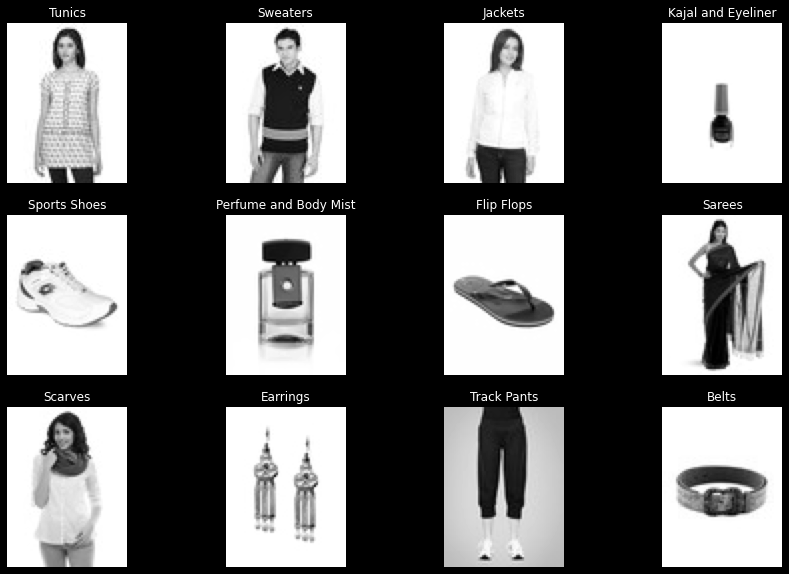

In [29]:
phase1.previewImgs()

In [30]:
#@title Phase2:
%%html
<div style="direction:rtl">
میخواهیم تعداد داده های هر دسته را به دست بیاوریم. برای این کار داده ها را دسته بندی میکنیم سپس تعداد را به دست آورد و مرتب می کنیم. در آخر نمودار آن را رسم می کنیم. همانطور که دیده می شود کلاس Tshirt بیشترین فراوانی و kajal and eyeliner کمترین فراوانی را در میان داده ها دارند.
</div>

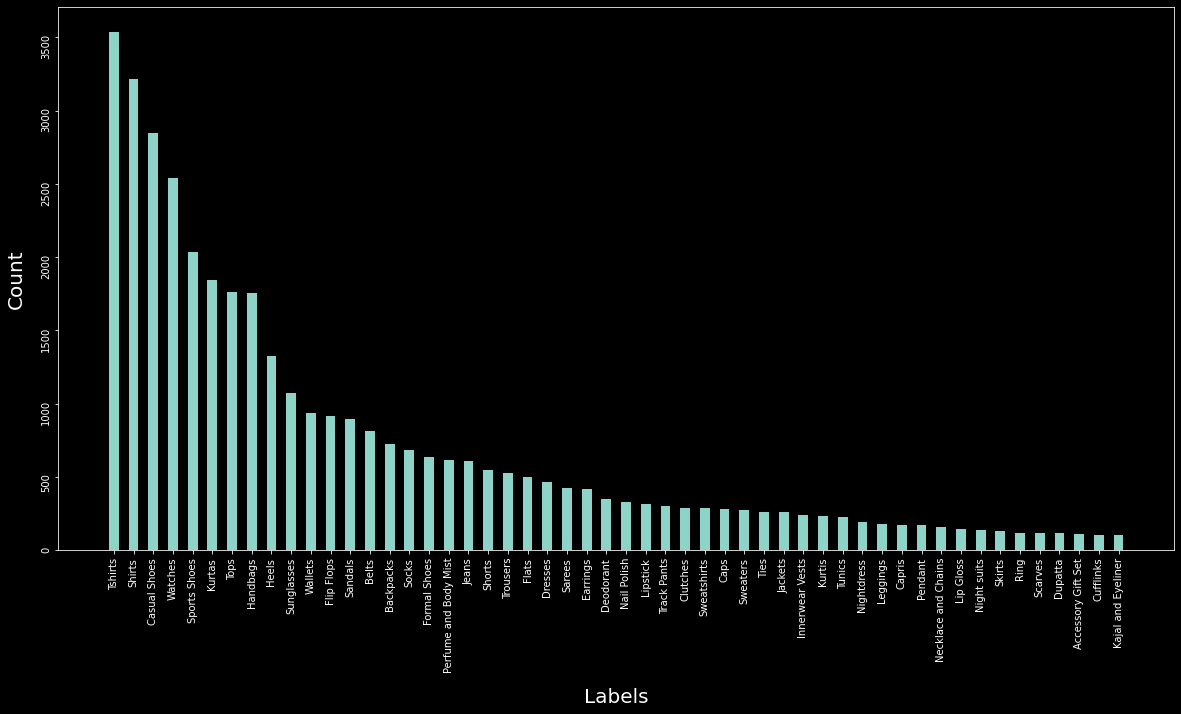

In [31]:
phase1.plotDistribution()

In [32]:
#@title Split train and test:
%%html
<div style="direction:rtl">
با استفاده از تابع Problem.splitData() داده ها را به دو دسته آموزش و ارزیابی تقسیم میکنیم برای این کار از تابع train_test_split استفاده می کنیم و برای اینکه داده متوازن داشته باشیم به طوری که درصد ثابتی از هر کاس در داده تست وجود داشته باشد از ویژگی stratify استفاده میکنیم.
</div>

In [110]:
#@title Phase3:
%%html
<div style="direction:rtl">
در این قسمت میخواهیم یک شبکه عصبی مناسب طرح کنیم. برای این کار از دوتا شبکه ۴ و ۵ لایه اسفاده میکنیم و با تغییر نودهای میانی سعی میکنیم بهترین دقت را به دست بیاوریم. در بعضی از حالت ها مقدار loss برابر با nan میشود که دلیل آن سرریز شدن این مقدار به دلیل بزرگ بود عدد است. از آنجا که داده ها در این بخش اسکیل نشده اند نتیجه خیلی خوبی به  دست نمی آوریم و میزان دقت بسیار پایین است.
</div>

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [111]:
phase3 = Problem()
phase3.initializeProblem([1, 1, 1 , 1], Model1, device)

In [112]:
phase3.splitData()

In [42]:
def optimizeNetworkModel1(problem):
    print("5 layer model:")
    dataModelList = [[20, 10, 300, 1000],
                    [2300, 1600, 800, 400],
                    [3500, 1500, 2000, 2500]]
    bestAccuracy = -1
    bestModalData = None
    for md in dataModelList:
        problem.initializeProblem(md, Model1, device)
        problem.printModelSummery()
        problem.fit(device)
        print("----")
        currentAccuracy = problem.calculateAccuracy(TEST)
        print("Accuracy:", currentAccuracy)
        print("*************")
        if bestAccuracy < currentAccuracy:
            bestModalData = md.copy()
            bestAccuracy = currentAccuracy
    return bestModalData, bestAccuracy

def optimizeNetworkModel2(problem):
    print("4 layer model:")
    dataModelList = [[20, 10, 1000],
                    [2300, 1400, 500],
                    [3500, 1500, 2000]]
    bestAccuracy = -1
    bestModalData = None
    for md in dataModelList:
        problem.initializeProblem(md, Model2, device)
        problem.printModelSummery()
        problem.fit(device)
        print("----")
        currentAccuracy = problem.calculateAccuracy(TEST)
        print("Accuracy:", currentAccuracy)
        print("*************")
        if  bestAccuracy < currentAccuracy:
            bestModalData = md.copy()
            bestAccuracy = currentAccuracy
    return bestModalData, bestAccuracy


In [37]:
optimizeNetworkModel1(phase3)

5 layer model:
Linear(in_features=4800, out_features=20, bias=True) 	 trainable count: 96020
Linear(in_features=20, out_features=10, bias=True) 	 trainable count: 210
Linear(in_features=10, out_features=300, bias=True) 	 trainable count: 3300
Linear(in_features=300, out_features=1000, bias=True) 	 trainable count: 301000
Linear(in_features=1000, out_features=52, bias=True) 	 trainable count: 52052
All trainable parameters: 452582
epoch 1, train_loss: 356.819, time elapsed: 12.275907 seconds
epoch 2, train_loss: 3.494, time elapsed: 12.280961 seconds
epoch 3, train_loss: 3.457, time elapsed: 12.39213 seconds
epoch 4, train_loss: 3.452, time elapsed: 12.346927 seconds
epoch 5, train_loss: 3.451, time elapsed: 12.273671 seconds
epoch 6, train_loss: 3.451, time elapsed: 12.482674 seconds
epoch 7, train_loss: 3.451, time elapsed: 12.190605 seconds
epoch 8, train_loss: 3.451, time elapsed: 12.390885 seconds
epoch 9, train_loss: 3.451, time elapsed: 12.340588 seconds
epoch 10, train_loss: 3.4

[3500, 1500, 2000, 2500]

In [113]:
optimizeNetworkModel2(phase3)

4 layer model:
Linear(in_features=4800, out_features=20, bias=True) 	 trainable count: 96020
Linear(in_features=20, out_features=10, bias=True) 	 trainable count: 210
Linear(in_features=10, out_features=1000, bias=True) 	 trainable count: 11000
Linear(in_features=1000, out_features=52, bias=True) 	 trainable count: 52052
All trainable parameters: 159282
epoch 1, train_loss: 72544.573, time elapsed: 12.836667 seconds
epoch 2, train_loss: 3.527, time elapsed: 12.937598 seconds
epoch 3, train_loss: 3.476, time elapsed: 12.652692 seconds
epoch 4, train_loss: 3.463, time elapsed: 12.685058 seconds
epoch 5, train_loss: 3.457, time elapsed: 12.672887 seconds
epoch 6, train_loss: 3.454, time elapsed: 12.854298 seconds
epoch 7, train_loss: 3.452, time elapsed: 13.089199 seconds
epoch 8, train_loss: 3.452, time elapsed: 12.720919 seconds
epoch 9, train_loss: 3.451, time elapsed: 12.816419 seconds
epoch 10, train_loss: 3.451, time elapsed: 12.733424 seconds
total training time: 2.133 minutes
----

([20, 10, 1000], 9.48993288590604)

از آنجا که فرایند آموزش تقریبا صورت نگرفته به دلیل اسکیل نبودن مقادیر به همه یک کلاس نسبت داده

epoch 1, train_loss: nan, time elapsed: 13.621276 seconds
epoch 2, train_loss: nan, time elapsed: 13.735359 seconds
epoch 3, train_loss: nan, time elapsed: 13.893987 seconds
epoch 4, train_loss: nan, time elapsed: 13.557913 seconds
epoch 5, train_loss: nan, time elapsed: 13.81601 seconds
epoch 6, train_loss: nan, time elapsed: 13.61411 seconds
epoch 7, train_loss: nan, time elapsed: 13.713548 seconds
epoch 8, train_loss: nan, time elapsed: 13.44389 seconds
epoch 9, train_loss: nan, time elapsed: 13.78872 seconds
epoch 10, train_loss: nan, time elapsed: 13.708527 seconds
total training time: 2.282 minutes
----
test accuracy: 0.2953020134228188
train accuracy: 0.29866774052820566


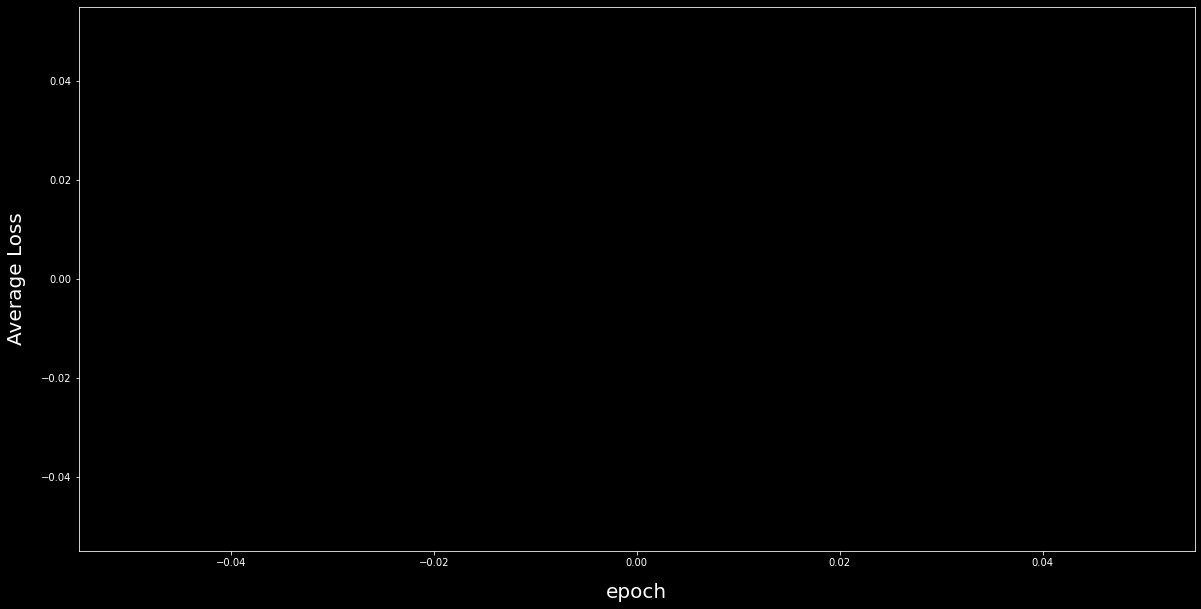

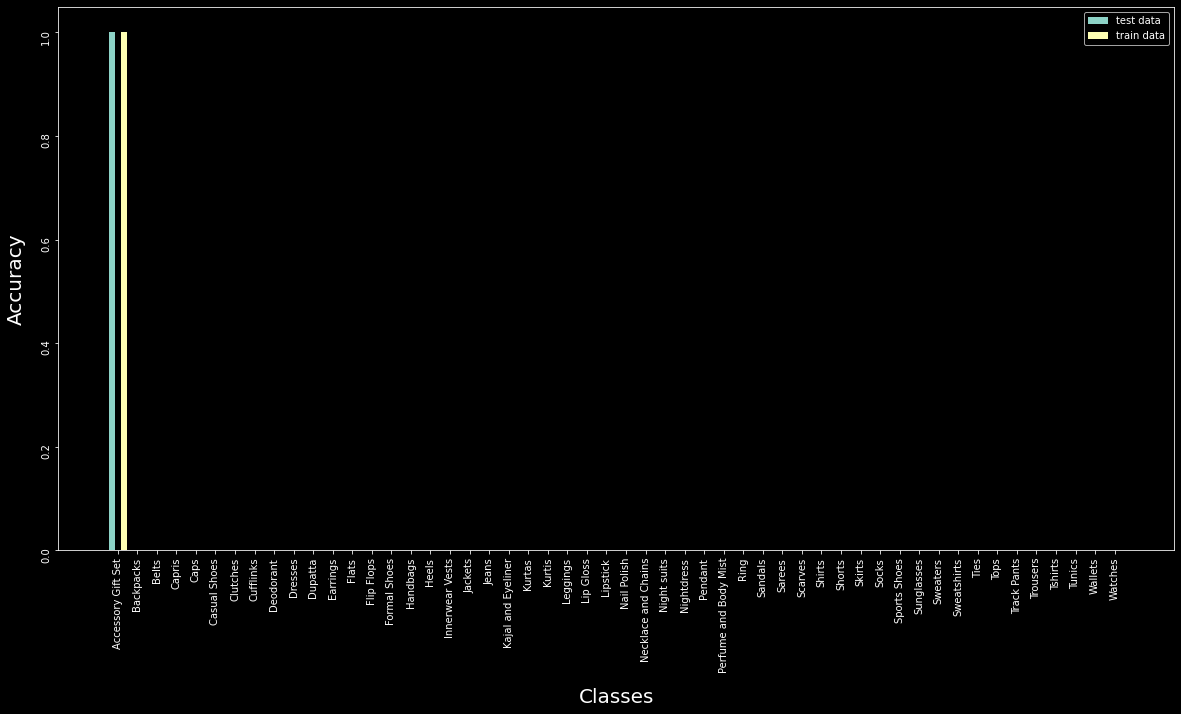

In [114]:
phase3 = Problem()
phase3.initializeProblem([3500, 1500, 2000], Model2, device)
phase3.splitData()
phase3.fit(device)
print("----")
print("test accuracy:", phase3.calculateAccuracy(TEST))
print("train accuracy:", phase3.calculateAccuracy(TRAIN))
phase3.plotEpochsLoss()
phase3.plotAccuracyPerClass()

In [40]:
#@title Trainable Prameters:
%%html
<div style="direction:rtl">
هر لایه از تعدادی نود ورودی و خروجی و بایاس تشکیل شده. تعداد پارامترهای قابل آموزش یا همان وزن ها از ضرب تعداد ورودی ها در خروجی ها (تعداد یال ها) به علاوه تعداد خروجی ها (به خاطر بایاس) به دست می آید.
</div>

In [41]:
phase3.printModelSummery()

Linear(in_features=4800, out_features=3500, bias=True) 	 trainable count: 16803500
Linear(in_features=3500, out_features=1500, bias=True) 	 trainable count: 5251500
Linear(in_features=1500, out_features=2000, bias=True) 	 trainable count: 3002000
Linear(in_features=2000, out_features=52, bias=True) 	 trainable count: 104052
All trainable parameters: 25161052


In [42]:
#@title Phase4:
%%html
<div style="direction:rtl">
در این قسمت داده ها را نرمال می کنیم. برای این کار بازه مقادیر پیکسل تصاویر را با تقسیم بر ۲۵۵ به ۰ تا ۱ انتقال می دهیم. تفاوت بسیار زیادی در نتایج مشاهده می شود. و دقت بسیار بهتر از حالت قبلی است.
</div>

In [17]:
phase4 = Problem(isScale=True)
phase4.initializeProblem([1, 1, 1 , 1], Model1, device)
phase4.splitData()

In [18]:
bestModalData1, bestAccuracy1 = optimizeNetworkModel1(phase4)

5 layer model:
Linear(in_features=4800, out_features=20, bias=True) 	 trainable count: 96020
Linear(in_features=20, out_features=10, bias=True) 	 trainable count: 210
Linear(in_features=10, out_features=300, bias=True) 	 trainable count: 3300
Linear(in_features=300, out_features=1000, bias=True) 	 trainable count: 301000
Linear(in_features=1000, out_features=52, bias=True) 	 trainable count: 52052
All trainable parameters: 452582
epoch 1, train_loss: 3.304, time elapsed: 12.973454 seconds
epoch 2, train_loss: 2.546, time elapsed: 13.168008 seconds
epoch 3, train_loss: 2.109, time elapsed: 12.991374 seconds
epoch 4, train_loss: 1.876, time elapsed: 12.959824 seconds
epoch 5, train_loss: 1.733, time elapsed: 12.962873 seconds
epoch 6, train_loss: 1.623, time elapsed: 12.93382 seconds
epoch 7, train_loss: 1.538, time elapsed: 13.151394 seconds
epoch 8, train_loss: 1.476, time elapsed: 12.965518 seconds
epoch 9, train_loss: 1.410, time elapsed: 12.866607 seconds
epoch 10, train_loss: 1.367

In [49]:
print("5 layer model:")
print("Best parameters: {}, Accuracy: {}".format(bestModalData1, bestAccuracy1))

Best parameters: [3500, 1500, 2000, 2500], Accuracy: 50.33557046979866


5 layer model
epoch 1, train_loss: 3.424, time elapsed: 14.437933 seconds
epoch 2, train_loss: 2.754, time elapsed: 14.226132 seconds
epoch 3, train_loss: 2.299, time elapsed: 14.187859 seconds
epoch 4, train_loss: 1.954, time elapsed: 14.20306 seconds
epoch 5, train_loss: 1.761, time elapsed: 14.180409 seconds
epoch 6, train_loss: 1.633, time elapsed: 14.109265 seconds
epoch 7, train_loss: 1.551, time elapsed: 14.245461 seconds
epoch 8, train_loss: 1.474, time elapsed: 14.206319 seconds
epoch 9, train_loss: 1.409, time elapsed: 14.342384 seconds
epoch 10, train_loss: 1.356, time elapsed: 14.159695 seconds
total training time: 2.372 minutes
----
test accuracy: 54.281879194630875
train accuracy: 54.26692170878217


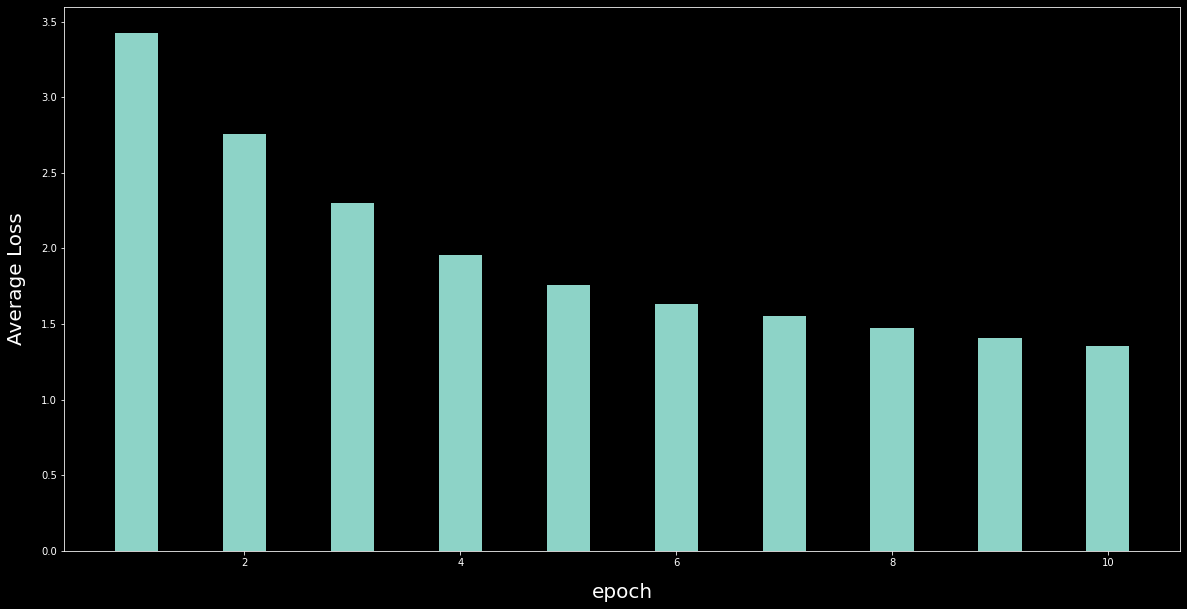

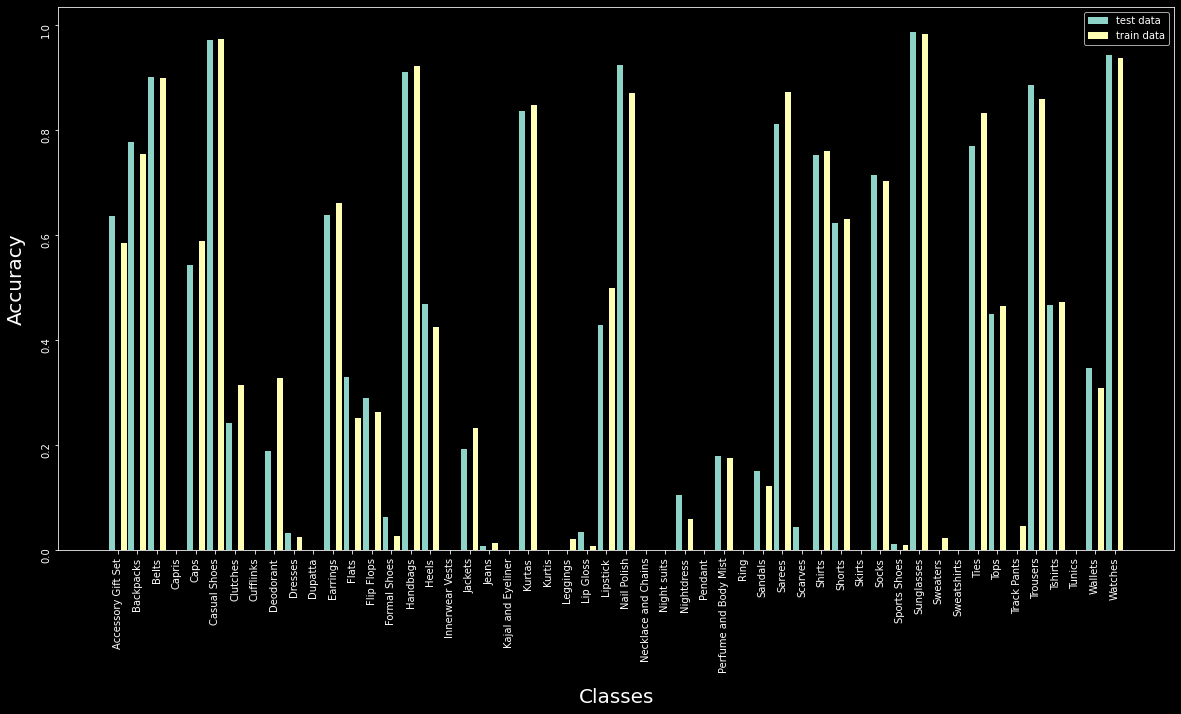

In [115]:
print("5 layer model")
phase4 = Problem(isScale=True)
phase4.initializeProblem(bestModalData1, Model1, device)
phase4.splitData()
phase4.fit(device)
print("----")
print("test accuracy:", phase4.calculateAccuracy(TEST))
print("train accuracy:", phase4.calculateAccuracy(TRAIN))
phase4.plotEpochsLoss()
phase4.plotAccuracyPerClass()

In [43]:
bestModalData2, bestAccuracy2 = optimizeNetworkModel2(phase4)

4 layer model:
Linear(in_features=4800, out_features=20, bias=True) 	 trainable count: 96020
Linear(in_features=20, out_features=10, bias=True) 	 trainable count: 210
Linear(in_features=10, out_features=1000, bias=True) 	 trainable count: 11000
Linear(in_features=1000, out_features=52, bias=True) 	 trainable count: 52052
All trainable parameters: 159282
epoch 1, train_loss: 2.930, time elapsed: 13.101112 seconds
epoch 2, train_loss: 2.185, time elapsed: 13.098236 seconds
epoch 3, train_loss: 1.895, time elapsed: 12.901362 seconds
epoch 4, train_loss: 1.732, time elapsed: 13.143598 seconds
epoch 5, train_loss: 1.600, time elapsed: 12.820902 seconds
epoch 6, train_loss: 1.530, time elapsed: 12.847889 seconds
epoch 7, train_loss: 1.457, time elapsed: 12.858944 seconds
epoch 8, train_loss: 1.403, time elapsed: 12.973513 seconds
epoch 9, train_loss: 1.366, time elapsed: 13.039958 seconds
epoch 10, train_loss: 1.333, time elapsed: 13.124076 seconds
total training time: 2.165 minutes
----
Acc

In [44]:
print("4 layer model:")
print("Best parameters: {}, Accuracy: {}".format(bestModalData2, bestAccuracy2))

4 layer model:
Best parameters: [3500, 1500, 2000], Accuracy: 60.40268456375839


In [ ]:
print("4 layer model")
phase4 = Problem(isScale=True)
phase4.initializeProblem(bestModalData2, Model1, device)
phase4.splitData()
phase4.fit(device)
print("----")
print("test accuracy:", phase4.calculateAccuracy(TEST))
print("train accuracy:", phase4.calculateAccuracy(TRAIN))
phase4.plotEpochsLoss()
phase4.plotAccuracyPerClass()

best model
epoch 1, train_loss: 3.126, time elapsed: 14.24627 seconds
epoch 2, train_loss: 2.328, time elapsed: 14.106037 seconds
epoch 3, train_loss: 1.941, time elapsed: 13.90592 seconds
epoch 4, train_loss: 1.703, time elapsed: 14.113282 seconds
epoch 5, train_loss: 1.556, time elapsed: 14.009508 seconds
epoch 6, train_loss: 1.458, time elapsed: 13.953062 seconds
epoch 7, train_loss: 1.368, time elapsed: 14.097895 seconds
epoch 8, train_loss: 1.307, time elapsed: 13.991669 seconds
epoch 9, train_loss: 1.259, time elapsed: 14.123271 seconds
epoch 10, train_loss: 1.209, time elapsed: 13.99318 seconds
total training time: 2.342 minutes
----
test accuracy: 58.76510067114094
train accuracy: 58.85432397060304


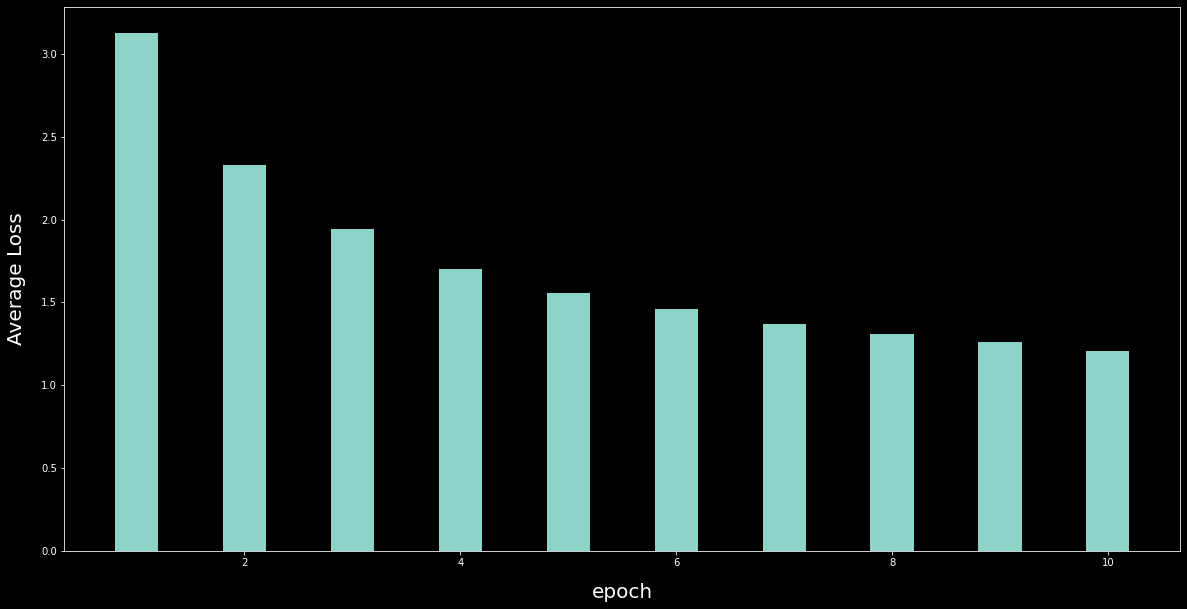

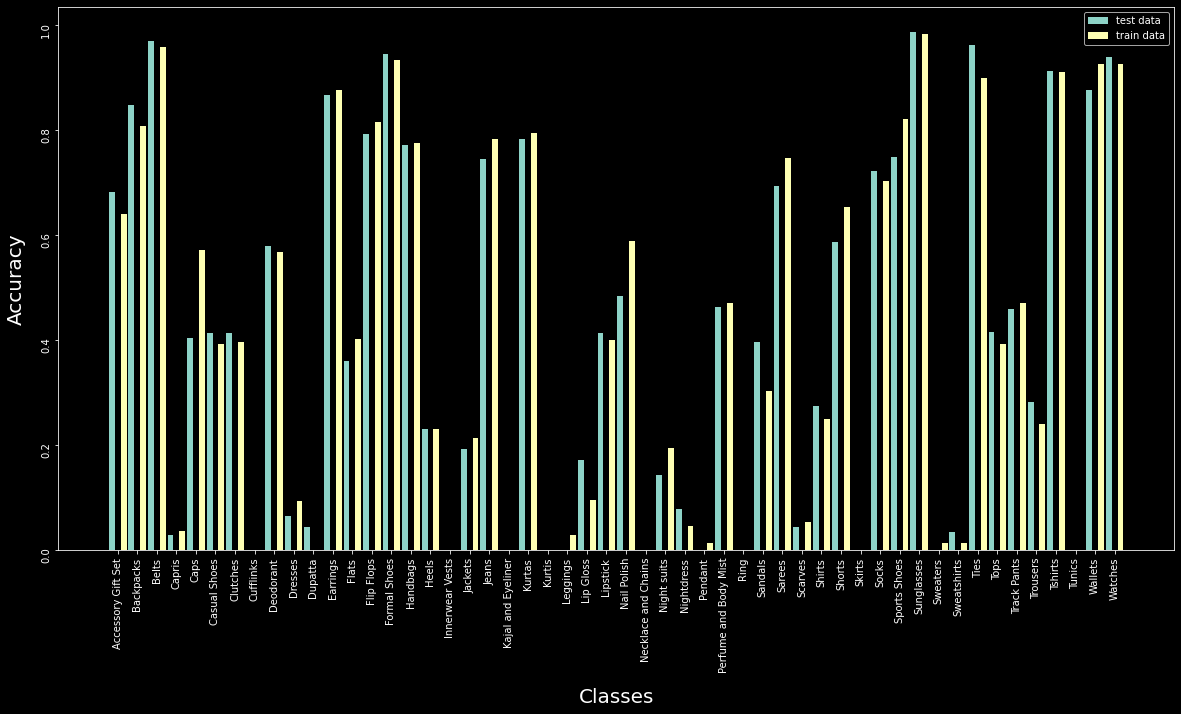

In [45]:
bestModel = None
bestModalData = None
if bestAccuracy2 > bestAccuracy1:
    bestModel = Model2
    bestModalData = bestModalData2
else:
    bestModel = Model1
    bestModalData = bestModalData1

print("best model")
phase4 = Problem(isScale=True)
phase4.initializeProblem(bestModalData, bestModel, device)
phase4.splitData()
phase4.fit(device)
print("----")
print("test accuracy:", phase4.calculateAccuracy(TEST))
print("train accuracy:", phase4.calculateAccuracy(TRAIN))
phase4.plotEpochsLoss()
phase4.plotAccuracyPerClass()

In [ ]:
#@title Phase5:
%%html
<div style="direction:rtl">
با این کار عملا شبکه به مدل خطی تبدیل می شود. چون همه نورون ها وزن یکسانی ورودی گرفته اند و آپدیت نمی شوند.
</div>

In [104]:
#@title وزن اولیه:
%%html
<div style="direction:rtl">
یکسان دادن وزن ها یا صفر دادن آنها باعث می شود که عملا آموزشی اتفاق نیفتد چون همه نودها به یک صورت آپدیت میشوند. بنابران یکی از روش های خوب استفاده از رندوم دادن وزن اولیه است تا هر کدام از یک جا شروع به یادگیری کنند و احتمال گیر کردن در مینیمم محلی کاهش پیدا کند.
</div>

epoch 1, train_loss: 3.884, time elapsed: 14.421816 seconds
epoch 2, train_loss: 3.746, time elapsed: 14.492753 seconds
epoch 3, train_loss: 3.580, time elapsed: 14.069671 seconds
epoch 4, train_loss: 3.460, time elapsed: 14.082236 seconds
epoch 5, train_loss: 3.424, time elapsed: 14.142398 seconds
epoch 6, train_loss: 3.332, time elapsed: 14.21524 seconds
epoch 7, train_loss: 3.270, time elapsed: 14.136206 seconds
epoch 8, train_loss: 3.220, time elapsed: 14.139799 seconds
epoch 9, train_loss: 3.179, time elapsed: 14.222011 seconds
epoch 10, train_loss: 3.147, time elapsed: 13.978338 seconds
total training time: 2.365 minutes
----
test accuracy: 11.302013422818792
train accuracy: 11.141313466894863


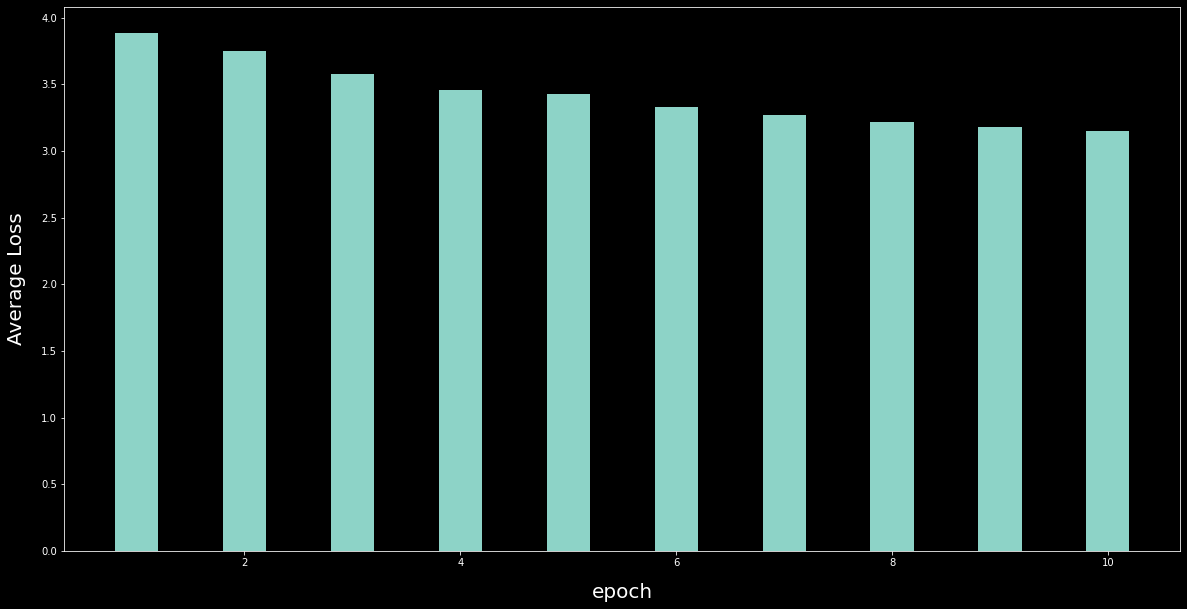

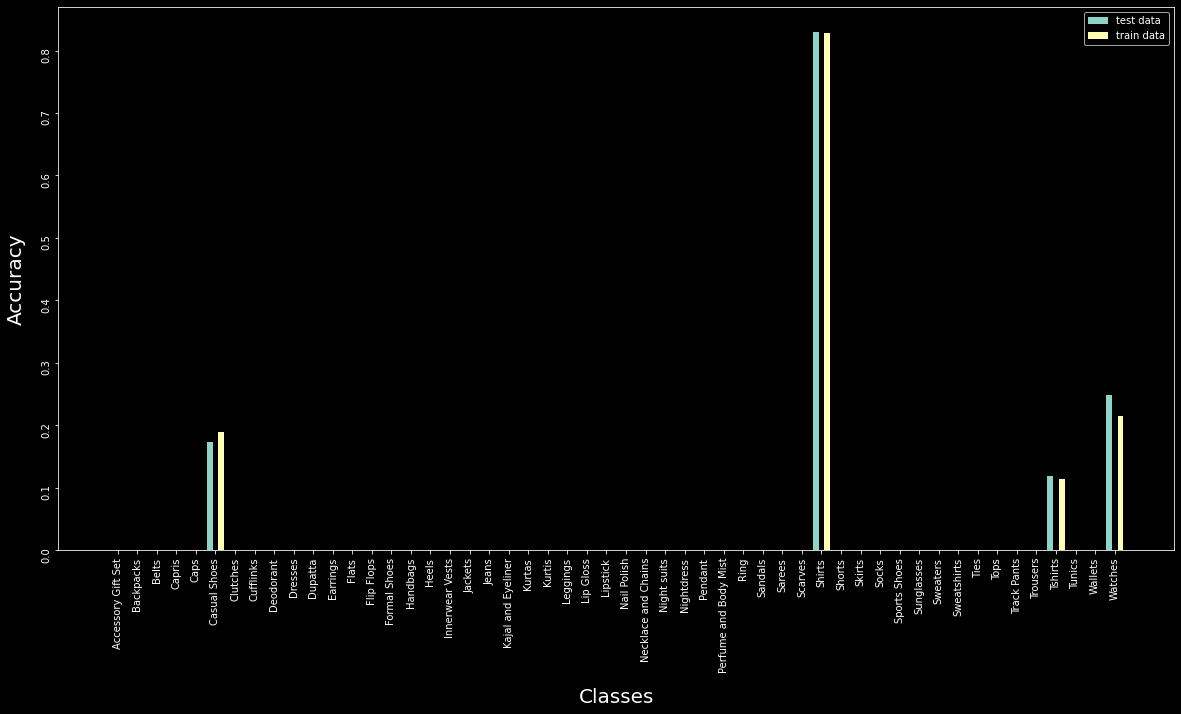

In [55]:
phase5 = Problem(isScale=True)
phase5.initializeProblem(bestModalData, Model2, device, initWeights=True)
phase5.splitData()
phase5.fit(device)
print("----")
print("test accuracy:", phase5.calculateAccuracy(TEST))
print("train accuracy:", phase5.calculateAccuracy(TRAIN))
phase5.plotEpochsLoss()
phase5.plotAccuracyPerClass()

In [105]:
#@title Phase6:
%%html
<div style="direction:rtl">
در این قسمت مقادیر مختلف نرخ یادگیری را امتحان می کنیم. اگر این مقدار خیلی زیاد باشد مد همگرا نمی شود و نوسان می کند و به نقطه بهینه همگرا نمی شود و اگر خیلی کوچک باشد ممکن است در نقطه اوپتیمم محلی گیر کند و همچنین سرعت آموزش بسیار کم می شود.
</div>

In [116]:
def findBestLearningRate(problem, bestModel, bestModelData, device):
    bestAccuracy = -1
    bestLearningRate = 0
    learningRates = [0.5, 0.2, 0.1, 0.07, 0.05, 0.01, 0.005, 0.001]
    accurecies = []
    for lr in learningRates:
        print("Learning Rate:", lr)
        problem.initializeProblem(bestModelData, bestModel, device, learningRate=lr)
        problem.fit(device)
        print("----")
        currentAccuracy = problem.calculateAccuracy(TEST)
        accurecies.append(currentAccuracy)
        print("Accuracy:", currentAccuracy)
        print("*************")
        if  bestAccuracy < currentAccuracy:
            bestLearningRate = lr
            bestAccuracy = currentAccuracy
    plotAcc(learningRates, accurecies, "Learning Rate", "Learning Rate", "Accuracy")
    return bestLearningRate

Learning Rate: 0.5
epoch 1, train_loss: 3.519, time elapsed: 14.266295 seconds
epoch 2, train_loss: 3.457, time elapsed: 13.982024 seconds
epoch 3, train_loss: 3.457, time elapsed: 13.949536 seconds
epoch 4, train_loss: 3.453, time elapsed: 13.970007 seconds
epoch 5, train_loss: 3.453, time elapsed: 14.178516 seconds
epoch 6, train_loss: 3.453, time elapsed: 14.268999 seconds
epoch 7, train_loss: 3.453, time elapsed: 14.070254 seconds
epoch 8, train_loss: 3.452, time elapsed: 14.274749 seconds
epoch 9, train_loss: 3.452, time elapsed: 14.130459 seconds
epoch 10, train_loss: 3.451, time elapsed: 14.192374 seconds
total training time: 2.355 minutes
----
Accuracy: 9.48993288590604
*************
Learning Rate: 0.2
epoch 1, train_loss: 3.484, time elapsed: 14.109623 seconds
epoch 2, train_loss: 3.414, time elapsed: 14.211643 seconds
epoch 3, train_loss: 3.404, time elapsed: 14.208654 seconds
epoch 4, train_loss: 3.133, time elapsed: 14.214827 seconds
epoch 5, train_loss: 2.949, time elapsed

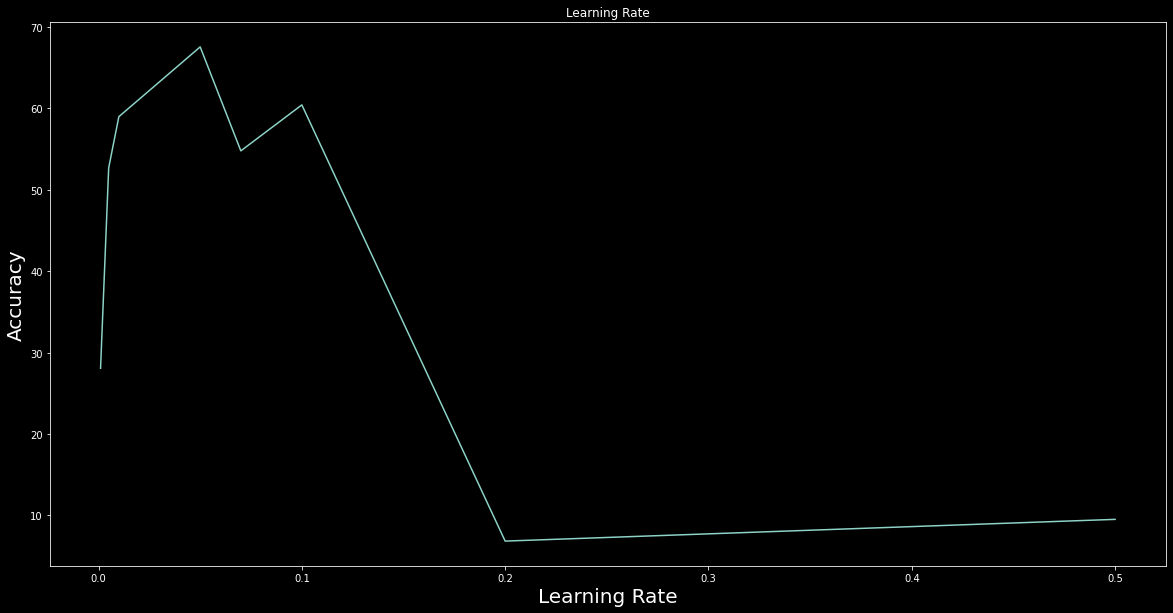

In [117]:
phase6 = Problem(isScale=True)
phase6.initializeProblem(bestModalData, Model2, device)
phase6.splitData()
bestLearningRate = findBestLearningRate(phase6, Model2, bestModalData, device)
print("Best Learning Rate:", bestLearningRate)


In [118]:
#@title Phase7:
%%html
<div style="direction:rtl">
در این بخش batch size های مختلف را امتحان می کنیم. این پارامتر یکی از پارامترهای مهم موثر بر سرعت همگرایی و رسیدن به جواب اوپتیمم است. اگر این پارامتر را بیشترین عدد ممکن یعنی برابر با سایز دیتاست قرار دهیم مطمین هستیم که به اوپتیمم اصلی میرسیم ولی باعث می شود سرعت کمتری داشته باشیم. از طرفی اگر این عدد بسیار کوچک باشد با سرعت خوبی به یک جواب خوب همگرا میشود که لزوما اوپتیمم سراسری نیست. در مقادیر کم قبل از دیدن یک بخش بزرگ از داده ها یادگیری آغاز می شود.
</div>

In [84]:
def findBestBatchSize(problem, bestModel, bestModelData, bestLearningRate, device):
    bestAccuracy = -1
    bestBatchSize = 0
    batchSizes = [32, 64, 128]
    accurecies = []
    for bs in batchSizes:
        print("Batch Size:", bs)
        problem.initializeProblem(bestModelData, bestModel, device, learningRate=bestLearningRate, batchSize=bs)
        problem.fit(device)
        print("----")
        currentAccuracy = problem.calculateAccuracy(TEST)
        accurecies.append(currentAccuracy)
        print("Accuracy:", currentAccuracy)
        print("*************")
        if  bestAccuracy < currentAccuracy:
            bestBatchSize = bs
            bestAccuracy = currentAccuracy
    plotAcc(batchSizes, accurecies, "Batch size", "Batch size", "Accuracy")    
    return bestBatchSize

Batch Size: 32
epoch 1, train_loss: 2.637, time elapsed: 14.231074 seconds
epoch 2, train_loss: 1.842, time elapsed: 14.261498 seconds
epoch 3, train_loss: 1.563, time elapsed: 13.970391 seconds
epoch 4, train_loss: 1.367, time elapsed: 14.060495 seconds
epoch 5, train_loss: 1.251, time elapsed: 13.784545 seconds
epoch 6, train_loss: 1.154, time elapsed: 14.005085 seconds
epoch 7, train_loss: 1.093, time elapsed: 13.817159 seconds
epoch 8, train_loss: 1.027, time elapsed: 14.012563 seconds
epoch 9, train_loss: 0.977, time elapsed: 14.165014 seconds
epoch 10, train_loss: 0.957, time elapsed: 13.935891 seconds
total training time: 2.337 minutes
----
Accuracy: 66.87248322147651
*************
Batch Size: 64
epoch 1, train_loss: 2.650, time elapsed: 14.049165 seconds
epoch 2, train_loss: 1.879, time elapsed: 14.229166 seconds
epoch 3, train_loss: 1.534, time elapsed: 14.10649 seconds
epoch 4, train_loss: 1.364, time elapsed: 14.057971 seconds
epoch 5, train_loss: 1.236, time elapsed: 14.240

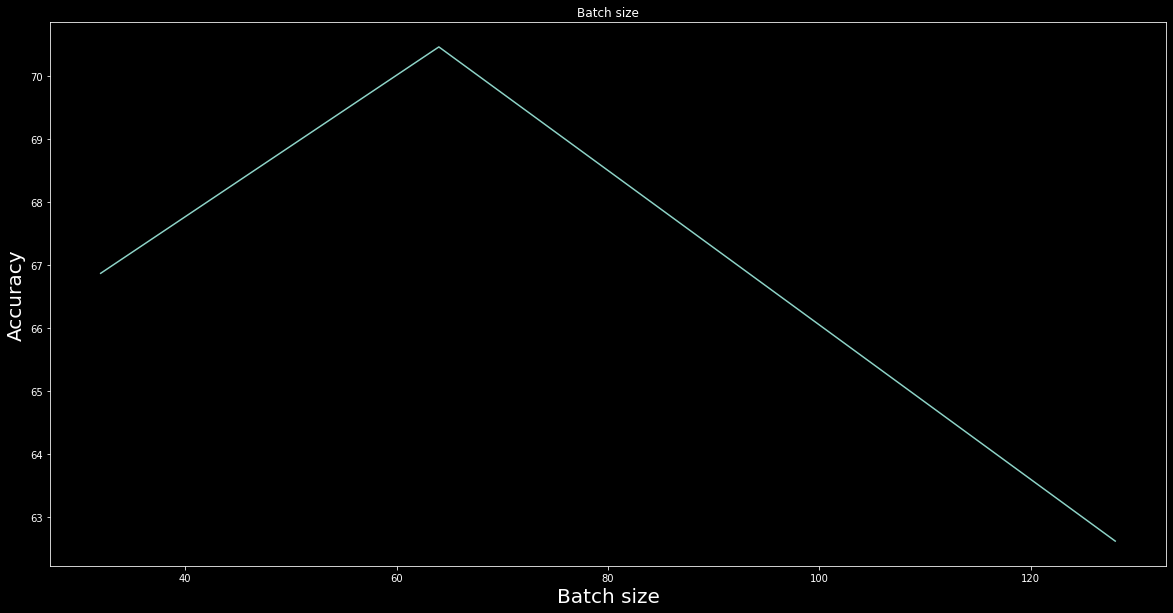

In [85]:
phase7 = Problem(isScale=True)
phase7.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate)
phase7.splitData()
bestBatchSize = findBestBatchSize(phase7, Model2, bestModalData, bestLearningRate, device)
print("Best Batch Size:", bestBatchSize)

In [91]:
#@title Learning Rate and Batch Size:
%%html
<div style="direction:rtl">
همانطور که دیده میشود در batch size بالا بهتر است از نرخ بالاتری برای یادگیری استفاده کنیم. به طور کلی از آنجایی که میزان batch size بالاتر تعداد داده بیشتری را برای آموزش میبیند پس می توان قدم های آموزش را بزرگتر و با اطمینان بیشتری برداشت.
</div>

In [89]:
phase7 = Problem(isScale=True)
phase7.initializeProblem(bestModalData, Model2, device, learningRate=0.1, batchSize=128)
phase7.splitData()
phase7.fit(device)
print("----")
print("accuracy test:", phase7.calculateAccuracy(TEST))
print("accuracy train:", phase7.calculateAccuracy(TRAIN))

epoch 1, train_loss: 3.211, time elapsed: 12.882436 seconds
epoch 2, train_loss: 2.495, time elapsed: 12.923984 seconds
epoch 3, train_loss: 2.137, time elapsed: 12.67305 seconds
epoch 4, train_loss: 1.935, time elapsed: 12.840564 seconds
epoch 5, train_loss: 1.661, time elapsed: 12.822662 seconds
epoch 6, train_loss: 1.522, time elapsed: 12.785004 seconds
epoch 7, train_loss: 1.421, time elapsed: 12.879846 seconds
epoch 8, train_loss: 1.332, time elapsed: 12.76328 seconds
epoch 9, train_loss: 1.234, time elapsed: 13.099149 seconds
epoch 10, train_loss: 1.213, time elapsed: 12.819856 seconds
total training time: 2.141 minutes
----
accuracy test: 62.48322147651007
accuracy train: 63.63971945367294


In [90]:
phase7.initializeProblem(bestModalData, Model2, device, learningRate=0.01, batchSize=128)
phase7.splitData()
phase7.fit(device)
print("----")
print("accuracy test:", phase7.calculateAccuracy(TEST))
print("accuracy train:", phase7.calculateAccuracy(TRAIN))

epoch 1, train_loss: 3.425, time elapsed: 12.949081 seconds
epoch 2, train_loss: 2.859, time elapsed: 12.899551 seconds
epoch 3, train_loss: 2.452, time elapsed: 13.082964 seconds
epoch 4, train_loss: 2.186, time elapsed: 13.001657 seconds
epoch 5, train_loss: 1.971, time elapsed: 12.995529 seconds
epoch 6, train_loss: 1.826, time elapsed: 13.053346 seconds
epoch 7, train_loss: 1.703, time elapsed: 13.145611 seconds
epoch 8, train_loss: 1.625, time elapsed: 13.069421 seconds
epoch 9, train_loss: 1.553, time elapsed: 13.057284 seconds
epoch 10, train_loss: 1.500, time elapsed: 13.021221 seconds
total training time: 2.171 minutes
----
accuracy test: 52.13422818791946
accuracy train: 52.30712440014766


In [106]:
#@title Phase8:
%%html
<div style="direction:rtl">
استفاده از momentum باعث میشود در مینیمم محلی گیر نیفتیم. این پارامتر با زیاد کردن قدم ها باعث میشود مدل بتواند در صورت گیر افتادن در مینیمم محلی خارج شود و احتمال یافتن مینیمم اصلی بیشتر میشود. اما اگر هم این مقدار و هم نرخ آموزش زیاد باشد ممکن است از روی مینیمم ها پرش کند. به طور کلی momentum بالا باعث میشود سریع همگرا شود. همانطور که دیده میشود در اینجا با مقدار ۰.۵ نتیجه بهتری کسب کردیم و با بالا بردن این عدد نتیجه بسیار بد شده. که می تواند بخاطر ترکیب نرخ آموزش و این اعداد باشد. بنابراین افزایش momentum ممکن است دقت را کاهش دهد و باعث بشود مینیمم را نیابیم.
</div>

In [98]:
def findBestMomentum(problem, bestModel, bestModelData, bestLearningRate, device):
    bestAccuracy = -1
    bestMomentum = 0
    momentums = [0.5, 0.9, 0.98]
    accurecies = []
    for m in momentums:
        print("Momentum:", m)
        problem.initializeProblem(bestModelData, bestModel, device, learningRate=bestLearningRate, momentum=m)
        problem.fit(device)
        print("----")
        currentAccuracy = problem.calculateAccuracy(TEST)
        accurecies.append(currentAccuracy)
        print("Accuracy:", currentAccuracy)
        print("*************")
        if  bestAccuracy < currentAccuracy:
            bestMomentum = m
            bestAccuracy = currentAccuracy
    plotAcc(momentums, accurecies, "Momentum", "Momentum", "Accuracy")
    return bestMomentum

Momentum: 0.5
epoch 1, train_loss: 2.989, time elapsed: 13.297589 seconds
epoch 2, train_loss: 2.155, time elapsed: 13.122849 seconds
epoch 3, train_loss: 1.966, time elapsed: 13.192467 seconds
epoch 4, train_loss: 1.584, time elapsed: 13.161018 seconds
epoch 5, train_loss: 1.416, time elapsed: 13.180665 seconds
epoch 6, train_loss: 1.335, time elapsed: 13.17017 seconds
epoch 7, train_loss: 1.201, time elapsed: 13.150025 seconds
epoch 8, train_loss: 1.138, time elapsed: 13.183278 seconds
epoch 9, train_loss: 1.084, time elapsed: 13.278892 seconds
epoch 10, train_loss: 1.032, time elapsed: 12.96844 seconds
total training time: 2.195 minutes
----
Accuracy: 65.26174496644295
*************
Momentum: 0.9
epoch 1, train_loss: 3.480, time elapsed: 13.138566 seconds
epoch 2, train_loss: 2.961, time elapsed: 13.197378 seconds
epoch 3, train_loss: 3.168, time elapsed: 13.059824 seconds
epoch 4, train_loss: 3.152, time elapsed: 13.164065 seconds
epoch 5, train_loss: 2.662, time elapsed: 13.053372

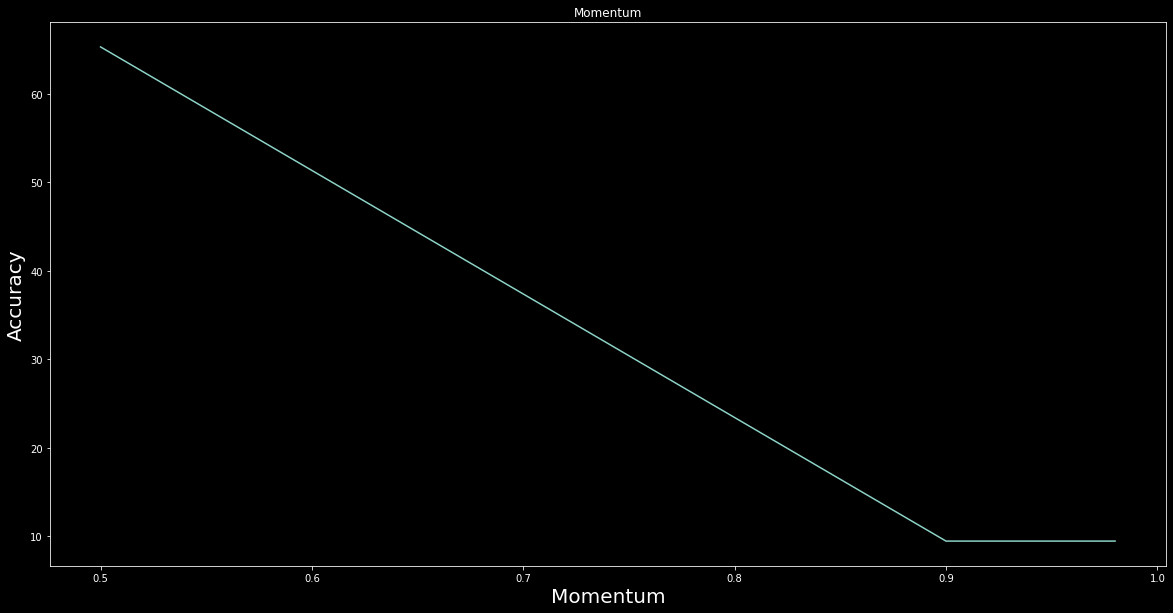

In [100]:
phase8 = Problem(isScale=True)
phase8.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate)
phase8.splitData()
bestMomentum = findBestMomentum(phase7, Model2, bestModalData, bestLearningRate, device)
print("Best Momentum:", bestMomentum)

In [107]:
#@title Phase9:
%%html
<div style="direction:rtl">
در این بخش تعداد تکرار را از ۱۰ به ۲۰ تغییر میدهیم. همانطور که دیده میشود نتیجه بهتر شده است. با تکرار آموزش کم کم مدل همگراتر میشود و احتمال افتادن در مینیمم های محلی نیز کاهش میابد چون هر بار از یک نقطه جدید شروع می کنیم. بنابراین داده ها را بهتر بررسی میکنیم. با این حال اگر تعداد تکرار بسیار زیاد باشد ممکن است overfitting اتفاق بیفتد و دقت داده ارزیابی کم شود. چون مدل بیش از حد مناسب برای داده آموزش میشود.
</div>

In [101]:
phase9 = Problem(isScale=True)
phase9.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum, epochs=20)
phase9.splitData()
phase9.fit(device)
print("----")
currentAccuracy = phase9.calculateAccuracy(TEST)
print("Accuracy test, epochs=20:", currentAccuracy)
currentAccuracy = phase9.calculateAccuracy(TRAIN)
print("Accuracy train, epochs=20:", currentAccuracy)

epoch 1, train_loss: 2.833, time elapsed: 14.471076 seconds
epoch 2, train_loss: 2.223, time elapsed: 14.353999 seconds
epoch 3, train_loss: 1.917, time elapsed: 14.517111 seconds
epoch 4, train_loss: 1.614, time elapsed: 14.43125 seconds
epoch 5, train_loss: 1.380, time elapsed: 14.633435 seconds
epoch 6, train_loss: 1.269, time elapsed: 14.585699 seconds
epoch 7, train_loss: 1.174, time elapsed: 14.487798 seconds
epoch 8, train_loss: 1.112, time elapsed: 14.542742 seconds
epoch 9, train_loss: 1.056, time elapsed: 14.639345 seconds
epoch 10, train_loss: 1.010, time elapsed: 14.598626 seconds
epoch 11, train_loss: 0.970, time elapsed: 14.624112 seconds
epoch 12, train_loss: 0.916, time elapsed: 14.510899 seconds
epoch 13, train_loss: 0.888, time elapsed: 14.670289 seconds
epoch 14, train_loss: 0.866, time elapsed: 14.536979 seconds
epoch 15, train_loss: 0.835, time elapsed: 14.600822 seconds
epoch 16, train_loss: 0.822, time elapsed: 14.641507 seconds
epoch 17, train_loss: 0.793, time 

In [119]:
#@title Phase10:
%%html
<div style="direction:rtl">
در این قسمت توابع مختلف را بررسی می کنیم. همانطور که دیده می شو تفاوت زیادی بین نتیج آنها نیست. تابع relu تابعی بسیار ساه است و پیچیدگی محاسباتی ندارد پس راحت تر اپتیمایز میشود و سریعتر همگرا میشود اما از آنجایی که به همه مقادیر منفی صفر نسبت میدهد اگر یک نودی صفر شود با احتمال کمی برمیگردد به همین خاطر از leaky_relu استفاده میشود که به جای صفر یک شیب منفی کوچک نسبت میدهد. تابع tanh بازه منفی ۱ تا ۱ را پوشش میدهد و منفی ها را بهتر بررسی میکند و این تابع نیز با سرعت مناسبی اپتیمایز میشود.
</div>

Activation Function:  relu
epoch 1, train_loss: 2.891, time elapsed: 14.50031 seconds
epoch 2, train_loss: 2.007, time elapsed: 14.989193 seconds
epoch 3, train_loss: 1.726, time elapsed: 14.446798 seconds
epoch 4, train_loss: 1.670, time elapsed: 14.597535 seconds
epoch 5, train_loss: 1.369, time elapsed: 14.413597 seconds
epoch 6, train_loss: 1.234, time elapsed: 14.328795 seconds
epoch 7, train_loss: 1.143, time elapsed: 14.442342 seconds
epoch 8, train_loss: 1.083, time elapsed: 14.435458 seconds
epoch 9, train_loss: 1.031, time elapsed: 14.366165 seconds
epoch 10, train_loss: 1.019, time elapsed: 14.38276 seconds
total training time: 2.415 minutes
----
Accuracy test: 66.06711409395973
Accuracy train: 66.83110171482265
*********
Activation Function:  tanh


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.230, time elapsed: 14.390691 seconds
epoch 2, train_loss: 1.462, time elapsed: 14.339944 seconds
epoch 3, train_loss: 1.263, time elapsed: 14.293046 seconds
epoch 4, train_loss: 1.153, time elapsed: 14.278258 seconds
epoch 5, train_loss: 1.058, time elapsed: 14.290226 seconds
epoch 6, train_loss: 0.997, time elapsed: 14.151921 seconds
epoch 7, train_loss: 0.953, time elapsed: 14.214778 seconds
epoch 8, train_loss: 0.897, time elapsed: 14.302893 seconds
epoch 9, train_loss: 0.876, time elapsed: 14.198258 seconds
epoch 10, train_loss: 0.837, time elapsed: 14.314709 seconds
total training time: 2.380 minutes
----
Accuracy test: 67.50335570469798
Accuracy train: 69.72046041813483
*********
Activation Function:  leaky_relu
epoch 1, train_loss: 2.606, time elapsed: 14.262692 seconds
epoch 2, train_loss: 1.843, time elapsed: 14.239844 seconds
epoch 3, train_loss: 1.583, time elapsed: 14.544901 seconds
epoch 4, train_loss: 1.353, time elapsed: 14.464754 seconds
epoch 5, 

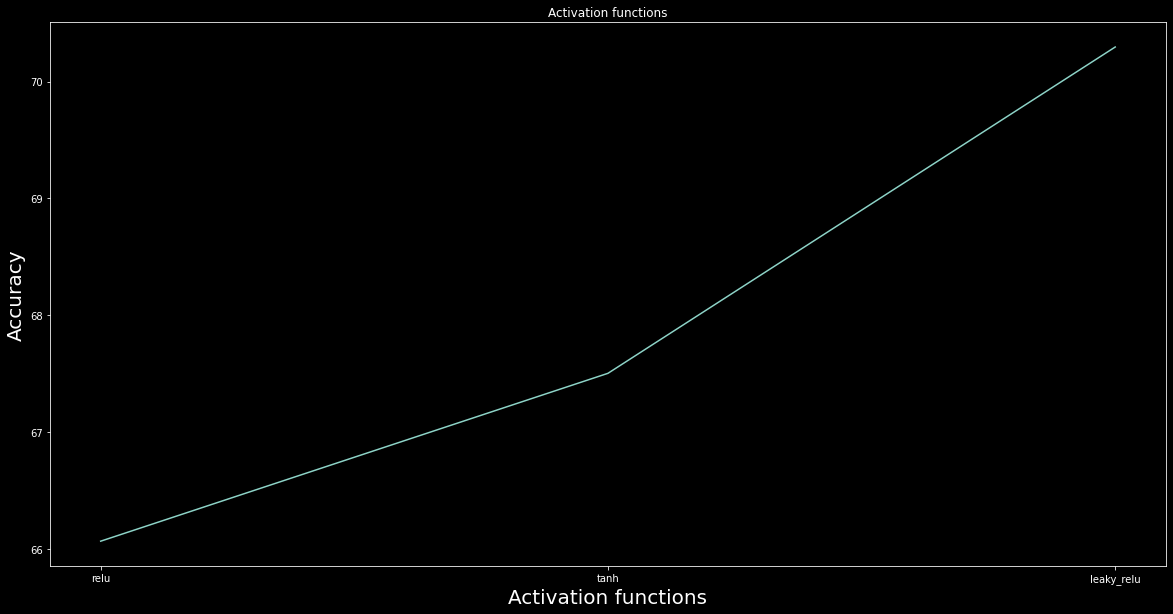

In [109]:
phase10 = Problem(isScale=True)
phase10.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum)
phase10.splitData()
i = 0
accurecies = []
names = ["relu", "tanh", "leaky_relu"]
for func in [F.relu, F.tanh, F.leaky_relu]:
    print("Activation Function: ", names[i])
    i+=1
    phase9.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum, activationFunction=func)
    phase9.fit(device)
    print("----")
    currentAccuracy = phase9.calculateAccuracy(TEST)
    accurecies.append(currentAccuracy)
    print("Accuracy test:", currentAccuracy)
    currentAccuracy = phase9.calculateAccuracy(TRAIN)
    print("Accuracy train:", currentAccuracy)
    print("*********")
plotAcc(names, accurecies, "Activation functions", "Activation functions", "Accuracy")


In [123]:
#@title Phase11:
%%html
<div style="direction:rtl">
این تکنیک برای ساده کردن مدل به کار می رود. اگر مدل بسیار پیچیده شود overfitting اتفاق میفتد و مدل دید کلیش را از دست میدهد. برای جلوگیری از این اتفاق میتوان از بزرگ شدن وزن ها جلوگیری کرد. با افزودن ترم regularizer وزن ها ساده تر میشود. weight_decay نیز از همین تکنیک استفاده میکند و با افزایش آن مدل ساده تر میشود و هرچه عدد آن بیشتر باشد بیشتر از overfitting در میشویم. در ادامه با بررسی نتیج متوجه میشویم که استفاده از weight_decay در کل باعث بهتر شدن نتیجه نسبت به فاز ۸ میشود اما از آنجا که مدل خیلی overfit نشده اگر weight_decay را زیاد انتخاب کنیم مدل زیادی ساده میشود و دقت کم میشود. پس یک عدد کوچک مثل ۰.۰۱ نتیجه را بهبود میبخشد 
</div>

In [121]:
phase11 = Problem(isScale=True)
phase11.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum, isRegularize=True, weightDecay=0.1)
phase11.splitData()
phase11.fit(device)
print("----")
currentAccuracy = phase11.calculateAccuracy(TEST)
print("Accuracy test:", currentAccuracy)
currentAccuracy = phase11.calculateAccuracy(TRAIN)
print("Accuracy train:", currentAccuracy)
print("*********")


epoch 1, train_loss: 2.376, time elapsed: 14.758973 seconds
epoch 2, train_loss: 1.721, time elapsed: 14.7342 seconds
epoch 3, train_loss: 1.397, time elapsed: 14.540327 seconds
epoch 4, train_loss: 1.242, time elapsed: 14.492823 seconds
epoch 5, train_loss: 1.142, time elapsed: 14.441701 seconds
epoch 6, train_loss: 1.062, time elapsed: 14.565975 seconds
epoch 7, train_loss: 1.004, time elapsed: 14.611795 seconds
epoch 8, train_loss: 0.953, time elapsed: 14.505947 seconds
epoch 9, train_loss: 0.912, time elapsed: 14.381416 seconds
epoch 10, train_loss: 0.875, time elapsed: 14.569506 seconds
total training time: 2.427 minutes
----
Accuracy test: 69.8255033557047
Accuracy train: 71.32118527467365
*********


In [122]:
phase11.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum, isRegularize=True, weightDecay=0.01)
phase11.fit(device)
print("----")
currentAccuracy = phase11.calculateAccuracy(TEST)
print("Accuracy test:", currentAccuracy)
currentAccuracy = phase11.calculateAccuracy(TRAIN)
print("Accuracy train:", currentAccuracy)
print("*********")


epoch 1, train_loss: 2.551, time elapsed: 14.454889 seconds
epoch 2, train_loss: 1.683, time elapsed: 14.477734 seconds
epoch 3, train_loss: 1.471, time elapsed: 14.501079 seconds
epoch 4, train_loss: 1.275, time elapsed: 14.276793 seconds
epoch 5, train_loss: 1.179, time elapsed: 14.363433 seconds
epoch 6, train_loss: 1.096, time elapsed: 14.742395 seconds
epoch 7, train_loss: 1.022, time elapsed: 14.630875 seconds
epoch 8, train_loss: 0.978, time elapsed: 14.445543 seconds
epoch 9, train_loss: 0.940, time elapsed: 14.408454 seconds
epoch 10, train_loss: 0.893, time elapsed: 14.559405 seconds
total training time: 2.414 minutes
----
Accuracy test: 71.02013422818791
Accuracy train: 72.05610926541159
*********


epoch 1, train_loss: 2.558, time elapsed: 14.792946 seconds
epoch 2, train_loss: 1.797, time elapsed: 14.481908 seconds
epoch 3, train_loss: 1.448, time elapsed: 14.438365 seconds
epoch 4, train_loss: 1.275, time elapsed: 14.745883 seconds
epoch 5, train_loss: 1.178, time elapsed: 14.427702 seconds
epoch 6, train_loss: 1.105, time elapsed: 14.527489 seconds
epoch 7, train_loss: 1.034, time elapsed: 14.614137 seconds
epoch 8, train_loss: 0.981, time elapsed: 14.363966 seconds
epoch 9, train_loss: 0.951, time elapsed: 14.517808 seconds
epoch 10, train_loss: 0.903, time elapsed: 14.322265 seconds
total training time: 2.421 minutes
----
Accuracy test: 66.28187919463087
Accuracy train: 66.89150642639015
*********


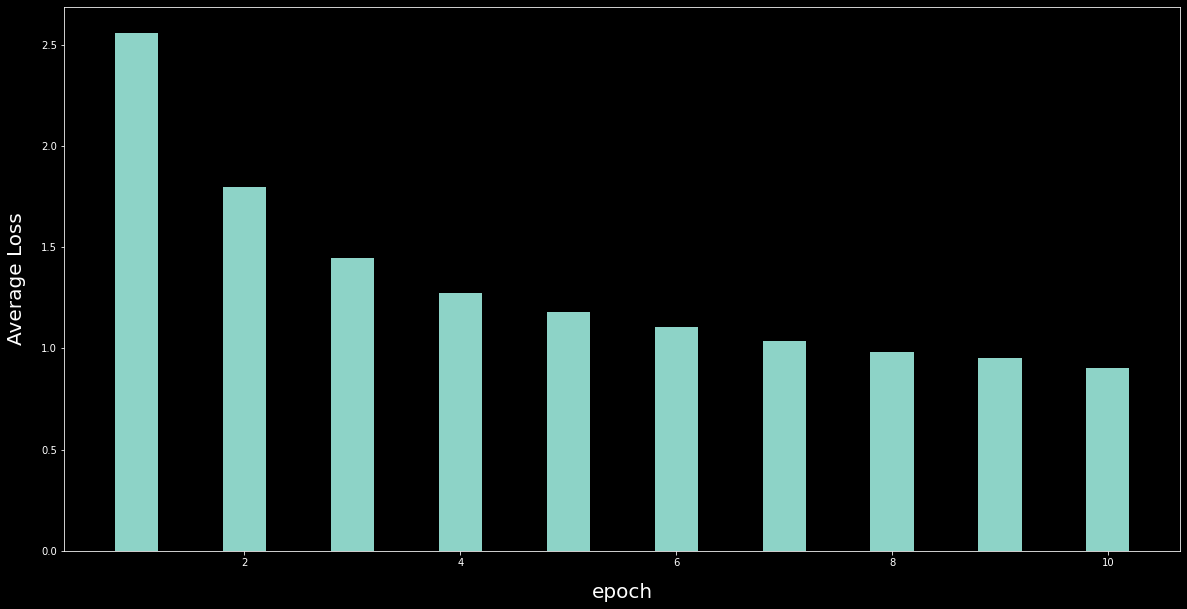

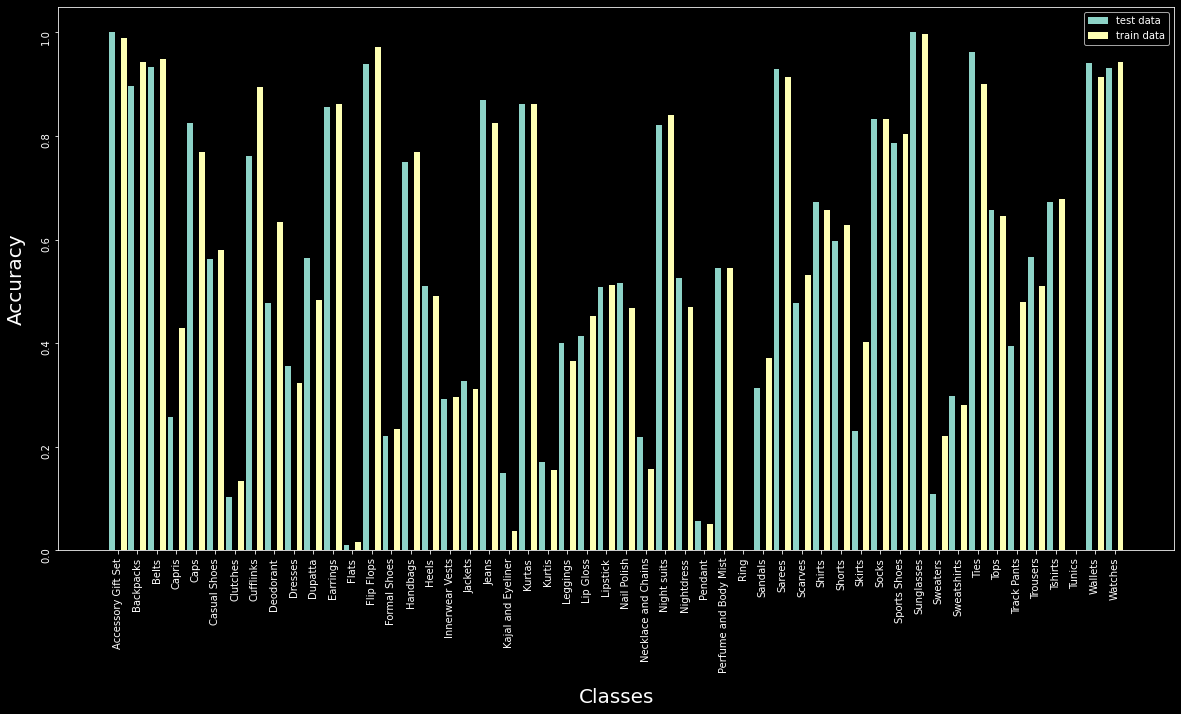

In [125]:
final = Problem(isScale=True)
final.initializeProblem(bestModalData, Model2, device, learningRate=bestLearningRate, momentum=bestMomentum, isRegularize=True, weightDecay=0.01)
final.splitData()
final.fit(device)
print("----")
currentAccuracy = final.calculateAccuracy(TEST)
print("Accuracy test:", currentAccuracy)
currentAccuracy = final.calculateAccuracy(TRAIN)
print("Accuracy train:", currentAccuracy)
print("*********")

final.plotEpochsLoss()
final.plotAccuracyPerClass()

منابع:

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

https://miguel-data-sc.github.io/2017-11-05-first/

https://www.quora.com/What-does-momentum-mean-in-neural-networks

https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044

https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3